<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/EBCM_no_markoviano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EBCM no-markoviano

Suponemos dados:


1.   $I(0)>0$, $S(0)=1-I(0)$, $R(0)=0$.
2.   $\psi$ la función generadora de probabilidad de la distribución de grados.
3.   $\theta(0)=\psi^{-1}(1-I(0))$
4.   $z(a)$, $\rho(a)$ funciones de riesgo de las distribuciones de transmisión y recuperación, independientes.

Para resolver el sistema de ecuaciones:
\begin{align}
\dot{\theta}(t)&=-\int_0^t z(a)\phi_I(t,a)da\\
\left(\frac{\partial }{\partial t}+\frac{\partial}{\partial a}\right)\phi_I(t,a)&=-\left(z(a)+\rho(a)\right)\phi_I(t,a)\\
\phi(t,0)&=\frac{\psi''(\theta(t))}{\psi'(1)}\int_0^t z(a)\phi_I(t,a)da\\
\left(\frac{\partial }{\partial t}+\frac{\partial}{\partial a}\right)i(t,a)&=-\rho(a)i(t,a)\\
i(t,0)&=\psi'(\theta(t))\int_0^t z(a)\phi_I(t,a)da\\
S(t)=\psi(\theta(t)), \quad &I(t)=\int_0^t i(t,a)da, \quad R(t)=1-S(t)-I(t)
\end{align}






In [99]:
import numpy as np
def EBCM_non_markovian(iniciales,riesgo_inf,riesgo_rec,fgp,fgp_prime_1,fgp_prime_2,step_len,fin):
  S_0,I_0,R_0,theta_0=iniciales
  z=riesgo_inf
  rho=riesgo_rec
  t,a,k=0,0,0
  T=[0]
  theta=[theta_0]
  phi_t_a=[I_0]
  i_t_a=[I_0]
  I=[I_0]
  h=step_len
  while(t<fin):
    k+=1
    phi_t_a_new=[]
    i_t_a_new=[]
    int_z_phi=np.sum([z(a+i*h)*phi_t_a[i] for i in range(len(phi_t_a))])*h
    #print("la integral es: ",int_z_phi)
    theta.append(theta[-1]-int_z_phi)
    #print("\theta=", theta[-1])
    phi_t_a_new.append(int_z_phi*fgp_prime_2(theta[-1]*0.5+0.5*theta_0)/fgp_prime_1(1))
    i_t_a_new.append(fgp_prime_1(theta[-1]*0.5+0.5*theta_0)*int_z_phi)
    theta_0=theta[-1]
    #print("Condiciones de frontera\n    \phi_I(t+dt,0)=",phi_t_a_new[-1],'\n    i(t+dt,0)=',i_t_a_new[-1])
    for j in range(k):
      phi_t_a_new.append(phi_t_a[j]-(rho(a+h*j)+z(a+h*j))*phi_t_a[j]*h)
      i_t_a_new.append(i_t_a[j]-(rho(a+h*j))*i_t_a[j]*h)
    I.append(np.sum(i_t_a_new))
    phi_t_a=phi_t_a_new
    i_t_a=i_t_a_new
    t+=h
    T.append(t)
    #print("I(t):",I[-1])
  return T,I

## Ejemplo

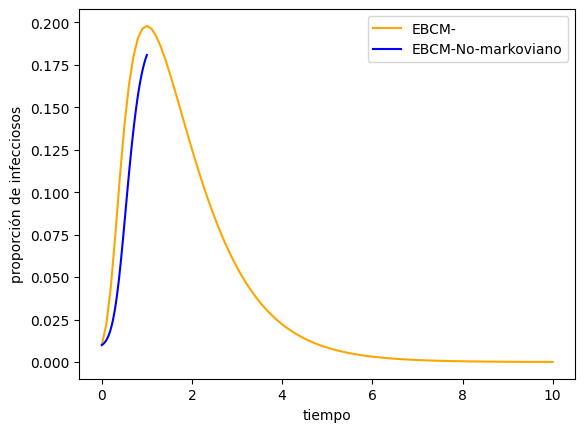

In [105]:
import matplotlib.pyplot as plt
def psi(x):
    return ((1/31)*(25*x+5*x**5+x**25))
def psi_prime_1(x):
    return (1/31)*(25+25*x**4+25*x**24)
def psi_prime_2(x):
    return (1/31)*(100*x**3+(25*24)*x**23)
from scipy.optimize import fsolve
I_0=0.01
def psi_CI(x):
  return psi(x)+I_0-1
theta_0=fsolve(psi_CI,1,)[0]
iniciales=[1-I_0,I_0,0,theta_0]
beta=1.2
gamma=1.0
def beta_cte(a):
    return beta
def gamma_cte(a):
    return gamma
T,I=EBCM_non_markovian(iniciales=iniciales,riesgo_inf=beta_cte,riesgo_rec=gamma_cte,fgp=psi,fgp_prime_1=psi_prime_1,fgp_prime_2=psi_prime_2,step_len=0.01,fin=1)
####
def EBCM_2(y, t, beta, gamma,psi,psi_prime):
    theta, R = y
    dydt = [-beta*theta+beta*(psi_prime(theta)/psi_prime(1))+gamma*(-theta+theta_0), gamma*(1-psi(theta)-R)]
    return dydt
from scipy.integrate import odeint
y0 = [theta_0, 0.0]
t = np.linspace(0, 10, 101)
sol_2 = odeint(EBCM_2, y0, t, args=(beta, gamma,psi,psi_prime_1))
plt.ylabel('proporción de infecciosos')
plt.xlabel('tiempo')
plt.plot(t,1-psi(sol_2[:,0])-sol_2[:,1],'orange',label='EBCM-')
plt.plot(T,I,'blue',label='EBCM-No-markoviano')
plt.legend()
plt.show()